# Explora aquí Web Scraping

Se recomienda utilizar este cuaderno con fines de exploración.

1: Instalación de dependencias e importaciones necesarias

In [1]:
import os
import requests
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dotenv import load_dotenv
from wordcloud import WordCloud

2: Descargar HTML

In [2]:
#Agregamos la URL en una variable
url = 'https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify'

# Realiza la solicitud http
response = requests.get(url)

#Solicitud para verificar el estado de la anterior solicitud HTTP
response.status_code

200

Paso 3: Transforma el HTML

In [3]:
# Verificamos si la solicitud fue exitosa
if response.status_code==200:
   
    #Usamos esta funcion que lee todas etiquetas <table> de URL y convierte esas tablas en dataframes
    # devolviendo una lista de esos dataframes
    tables = pd.read_html(url)
    
    #Generar el dataframe df_canciones a partir de la primera tabla existente en la URL
    df_canciones = tables[0]
    #print(df_canciones.head())

else:
    print(f"Ocurrió un error: {response.status_code}")

4: Procesa el DataFrame

In [4]:
# Eliminamos la columna ref ya que no tiene utilidad en nuestro contexto como parte del proceso de limpieza
# no encuentro valores nulos ni vacios en la tabla asi que no elimino nada mas
canciones_stremadas = df_canciones.drop(columns="Ref.")
#print(canciones_stremadas.head())

5: Almacena los datos en sqlite

In [5]:
# Cargar variables de entorno
load_dotenv(override=True)
db_path = os.getenv("DB_PATH")

#print(db_path)

# Conectarse a la base de datos y guardar el DataFrame
conn = sqlite3.connect(db_path)
canciones_stremadas.to_sql("canciones", conn, if_exists="replace", index=False)
conn.close()

# Hacemos consulta de la tabla canciones
conn = sqlite3.connect(db_path)
df2 = pd.read_sql("SELECT * FROM canciones", conn)
print(df2.head(5))
conn.close()

  Rank                 Song                 Artist(s) Streams (billions)  \
0    1    "Blinding Lights"                The Weeknd              4.825   
1    2       "Shape of You"                Ed Sheeran              4.346   
2    3  "Someone You Loved"             Lewis Capaldi              3.893   
3    4            "Starboy"  The Weeknd and Daft Punk              3.877   
4    5          "As It Was"              Harry Styles              3.864   

        Release date  
0   29 November 2019  
1     6 January 2017  
2    8 November 2018  
3  21 September 2016  
4       1 April 2022  


6: Visualiza los datos (opcional, pero muy recomendado)

6.1 Grafica propuesta 1: Palabras mas usadas en los tituos de las canciones top mostradas como una nube de palabras

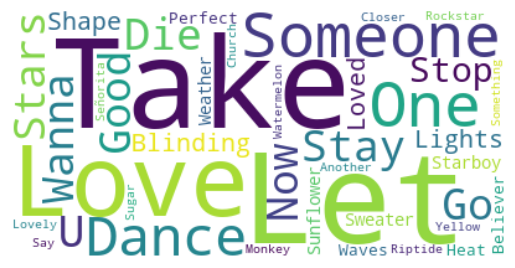

In [20]:
#creamos un ciclo que recorra todas las canciones y las trandorme en una lista en txt
txt=''
for cancion in canciones_stremadas.Song:
    txt=txt + cancion + ' '
#print(txt)

# Creamos y generamos una imagen de nube de palabras
wordcloud = WordCloud(max_words=40, background_color="white").generate(txt)

# Mostramos la imagen creada
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

6.2 Grafica propuesta 2: Artistas con mas contribuciones en la lista top 100

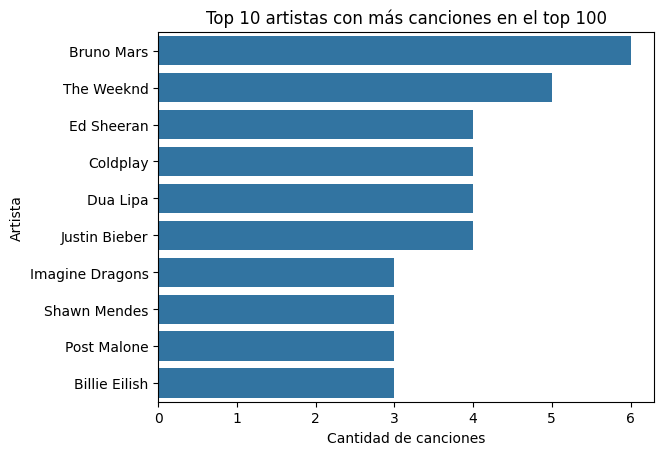

In [ ]:

canciones_artistas=canciones_stremadas

# Procesamos la columna artistas para que en el caso de las colaboraciones cada artista cuente
#  separamos, usamos explode y eliminamos espacios para que el conteo sea valido
canciones_artistas['Artist_norm'] = canciones_artistas['Artist(s)'].str.split('and')
canciones_artistas = canciones_artistas.explode('Artist_norm')
canciones_artistas['Artist_norm'] = canciones_artistas['Artist_norm'].str.strip()

# Contamos los artistas y obtenemos el top 10
top_artistas = canciones_artistas['Artist_norm'].value_counts().head(10)

# Creamos un gráfico de barras
sns.barplot(x=top_artistas.values, y=top_artistas.index)
plt.xlabel('Cantidad de canciones')
plt.ylabel('Artista')
plt.title('Top 1# Copiamos el dataframe original en otro para no alterarlo0 artistas con más canciones en el top 100')
plt.show()


6.3 Grafica propuesta 3: Año en que fueron lanzadas las canciones del top 100  2025

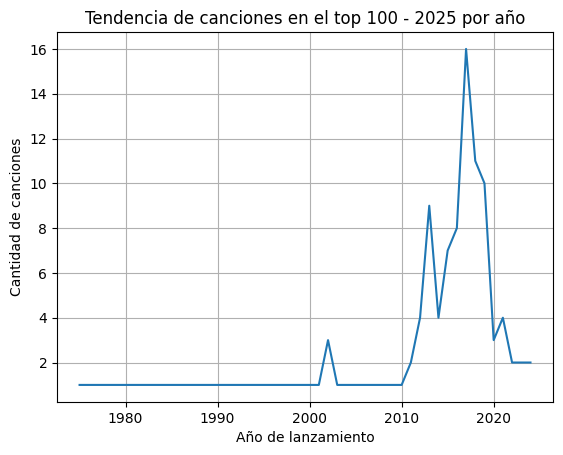

In [ ]:
# Copiamos el dataframe original en otro para no alterarlo
canciones_año=canciones_stremadas

# Procesamos la columna año la formateamos y pedimos ignorar o interpretar datos que no esten en el formato
canciones_año['Release date'] = pd.to_datetime(canciones_año['Release date'], errors='coerce')

# Separamos el dato del año en una columna y los contamos
canciones_año['año de lanzamiento'] = canciones_año['Release date'].dt.year
canciones_por_año = canciones_año['año de lanzamiento'].value_counts().sort_index()

# Generamos la grafica 
sns.lineplot(x=canciones_por_año.index, y=canciones_por_año.values )
plt.xlabel('Año de lanzamiento')
plt.ylabel('Cantidad de canciones')
plt.title('Año de lanzamiento de las canciones en el top 100 - 2025')
plt.grid('both')
plt.show()